In [2]:
import pandas as pd

df = pd.read_csv("government-procurement-via-gebiz.csv")  
df.head()


,tender_no.,tender_description,agency,award_date,tender_detail_status,supplier_name,awarded_amt
0,ACR000ETT14000007,Provision Of Event Management And Related Serv...,Accounting And Corporate Regulatory Authority,6/2/2015,Awarded to No Suppliers,Unknown,0.00
1,ACR000ETT14000008,Invitation To Tender For The Provision Of Alte...,Accounting And Corporate Regulatory Authority,30/4/2015,Awarded to No Suppliers,Unknown,0.00
2,ACR000ETT14000009,Invitation To Tender For The Provision Of Manp...,Accounting And Corporate Regulatory Authority,28/1/2015,Awarded to Suppliers,RMA CONTRACTS PTE. LTD.,76071.21
3,ACR000ETT15000004,Invitation To Tender For The Provision Of Manp...,Accounting And Corporate Regulatory Authority,1/7/2015,Awarded to Suppliers,TESCOM (SINGAPORE) SOFTWARE SYSTEMS TESTING PT...,84000.00
4,ACR000ETT15000005,Proposed Interior Fitting Out Works for ACRA's...,Accounting And Corporate Regulatory Authority,24/4/2015,Awarded to Suppliers,MKS GLOBAL PTE. LTD.,653255.00


In [3]:
print("Rows, Columns:", df.shape)
print(df.info())  # data types, non-null counts


Rows, Columns: (32756, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32756 entries, 0 to 32755
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tender_no.            32756 non-null  object 
 1   tender_description    32756 non-null  object 
 2   agency                32756 non-null  object 
 3   award_date            32756 non-null  object 
 4   tender_detail_status  32756 non-null  object 
 5   supplier_name         32756 non-null  object 
 6   awarded_amt           32756 non-null  float64
dtypes: float64(1), object(6)
memory usage: 1.7+ MB
None


#Convert award_date to datetime type for date-based analysis

In [5]:
df['award_date'] = pd.to_datetime(df['award_date'], dayfirst=True, errors='coerce')
print(df['award_date'].head())


0   2015-02-06
1   2015-04-30
2   2015-01-28
3   2015-07-01
4   2015-04-24
Name: award_date, dtype: datetime64[ns]


In [6]:
print("Tender Detail Status Counts:\n", df['tender_detail_status'].value_counts(), "\n")

print("Number of Unique Agencies:", df['agency'].nunique())
print("Top 5 Agencies:\n", df['agency'].value_counts().head(), "\n")

print("Number of Unique Suppliers:", df['supplier_name'].nunique())
print("Top 5 Suppliers:\n", df['supplier_name'].value_counts().head())


Tender Detail Status Counts:
 tender_detail_status
Awarded to Suppliers       26257
Awarded by Items            5085
Awarded to No Suppliers     1414
Name: count, dtype: int64 

Number of Unique Agencies: 122
Top 5 Agencies:
 agency
Housing and Development Board                    2223
Public Utilities Board                           2120
People's Association                             1534
Agency for Science, Technology and Research      1493
Ministry of Home Affairs-Ministry Headquarter    1396
Name: count, dtype: int64 

Number of Unique Suppliers: 8633
Top 5 Suppliers:
 supplier_name
Unknown                                 1414
NCS PTE. LTD.                            284
SURBANA JURONG CONSULTANTS PTE. LTD.     148
KPMG SERVICES PTE. LTD.                  137
ERNST & YOUNG ADVISORY PTE. LTD.         120
Name: count, dtype: int64


In [7]:
#Create taget variables break_risk

In [9]:
df['breach_risk'] = 0
df.loc[df['tender_detail_status'] == 'Awarded to No Suppliers', 'breach_risk'] = 1
df.loc[df['awarded_amt'] == 0, 'breach_risk'] = 1
df.loc[df['supplier_name'] == 'Unknown', 'breach_risk'] = 1


In [11]:
#Extract year and month from award_date to spot seasonal trends.

In [12]:
df['award_year'] = df['award_date'].dt.year
df['award_month'] = df['award_date'].dt.month


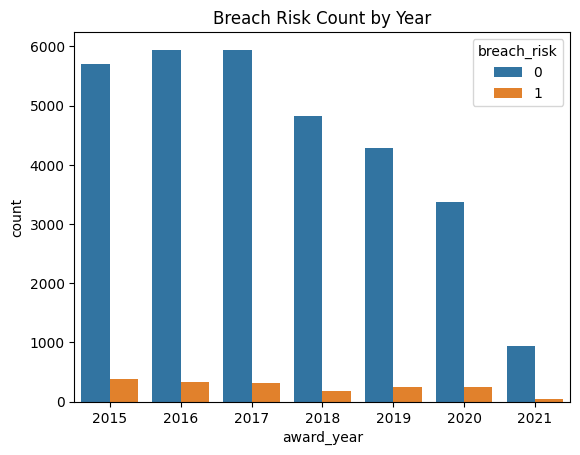

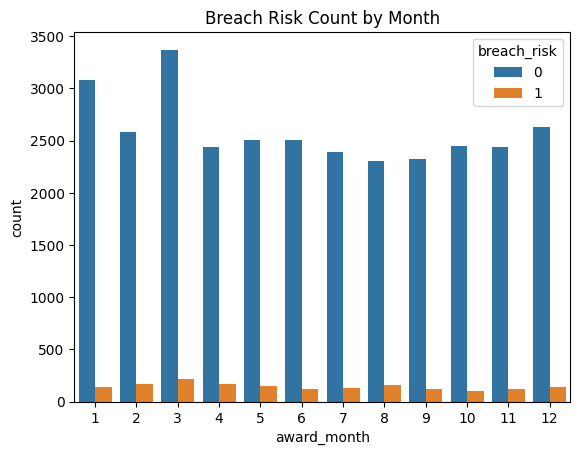

In [13]:
#How does breach risk vary across years and months?
import seaborn as sns
import matplotlib.pyplot as plt

# Breach risk count by year
sns.countplot(x='award_year', hue='breach_risk', data=df)
plt.title('Breach Risk Count by Year')
plt.show()

# Breach risk count by month
sns.countplot(x='award_month', hue='breach_risk', data=df)
plt.title('Breach Risk Count by Month')
plt.show()


agency
Ministry of Home Affairs - Ministry Headquarter 1                        1.000000
Singapore Labour Foundation                                              0.272727
Housing and Development Board                                            0.168241
Ministry of Defence 5                                                    0.166667
Duke-NUS Medical School                                                  0.151515
Prime Minister's Office - Strategy Group                                 0.147059
Methodist Girls' School (Secondary)                                      0.146341
School of Science and Technology, Singapore                              0.142857
Prime Minister's Office - National Security Co-ordination Secretariat    0.125000
Accounting And Corporate Regulatory Authority                            0.121951
Name: breach_risk, dtype: float64


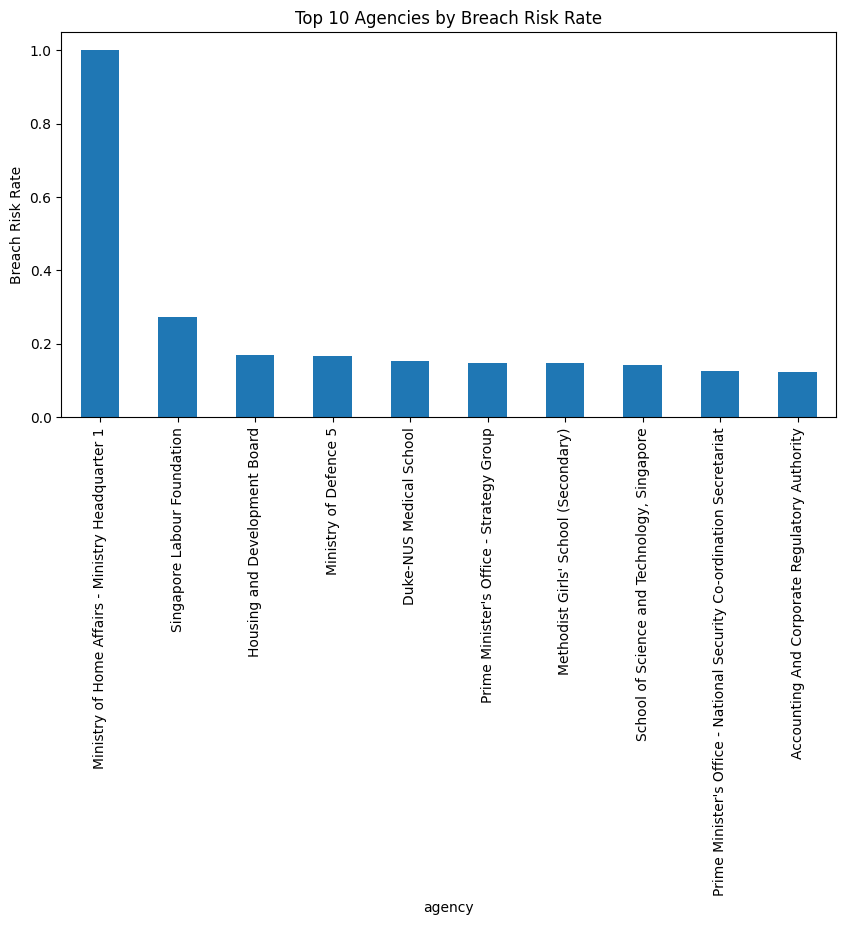

In [14]:
# Analyze breach risk by agency
agency_breach = df.groupby('agency')['breach_risk'].mean().sort_values(ascending=False)
print(agency_breach.head(10))

# Plot top 10 agencies with highest breach risk
agency_breach.head(10).plot(kind='bar', figsize=(10,5), title='Top 10 Agencies by Breach Risk Rate')
plt.ylabel('Breach Risk Rate')
plt.show()


In [15]:
#Process text feature (tender_description)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tender_desc_tfidf = tfidf.fit_transform(df['tender_description'])
print(tender_desc_tfidf.shape)


(32756, 1000)


In [16]:
#Encode agency and supplier_name
agency_freq = df['agency'].value_counts(normalize=True)
supplier_freq = df['supplier_name'].value_counts(normalize=True)

df['agency_freq'] = df['agency'].map(agency_freq)
df['supplier_freq'] = df['supplier_name'].map(supplier_freq)


In [17]:
#Prepare dataset for modeling
import numpy as np
import scipy.sparse as sp

# Numeric features
numeric_features = df[['awarded_amt', 'award_year', 'award_month', 'agency_freq', 'supplier_freq']].fillna(0)

# Combine numeric + TF-IDF sparse matrix horizontally
X = sp.hstack([sp.csr_matrix(numeric_features.values), tender_desc_tfidf])

# Target
y = df['breach_risk']


In [18]:
#Split and train a classification model (Logistic Regression or Decision Tree)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6205
           1       0.97      1.00      0.99       347

    accuracy                           1.00      6552
   macro avg       0.99      1.00      0.99      6552
weighted avg       1.00      1.00      1.00      6552

ROC AUC: 0.9998467351095031


In [19]:
#Validate your model with cross-validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(f"Cross-validated ROC AUC scores: {cv_scores}")
print(f"Mean ROC AUC: {cv_scores.mean():.4f}")


Cross-validated ROC AUC scores: [0.9997989  0.99979747 0.99816517 0.99909188 0.99991406]
Mean ROC AUC: 0.9994


In [20]:
#Analyze feature importance:For logistic regression, extract coefficients:

feature_names = list(numeric_features.columns) + list(tfidf.get_feature_names_out())
coefficients = model.coef_[0]

# Top positive features increasing breach risk
top_pos = np.argsort(coefficients)[-10:]
print("Top features positively correlated with breach risk:")
for i in top_pos[::-1]:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

# Top negative features (decreasing breach risk)
top_neg = np.argsort(coefficients)[:10]
print("\nTop features negatively correlated with breach risk:")
for i in top_neg:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")


Top features positively correlated with breach risk:
supplier_freq: 1.3547
supply: 1.0147
maintenance: 0.8244
installation: 0.6949
singapore: 0.6080
commissioning: 0.5908
design: 0.5616
projects: 0.5561
repair: 0.5362
months: 0.5240

Top features negatively correlated with breach risk:
awarded_amt: -9.0006
panel: -2.8432
valuers: -2.2485
dec: -2.0692
jan: -2.0603
consultants: -1.9727
2021: -1.6602
31: -1.6030
years: -1.5550
interior: -1.5060


C:\tmp\ipykernel_6400\3343952291.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(pos_features.values()), y=list(pos_features.keys()), palette="Greens_d")


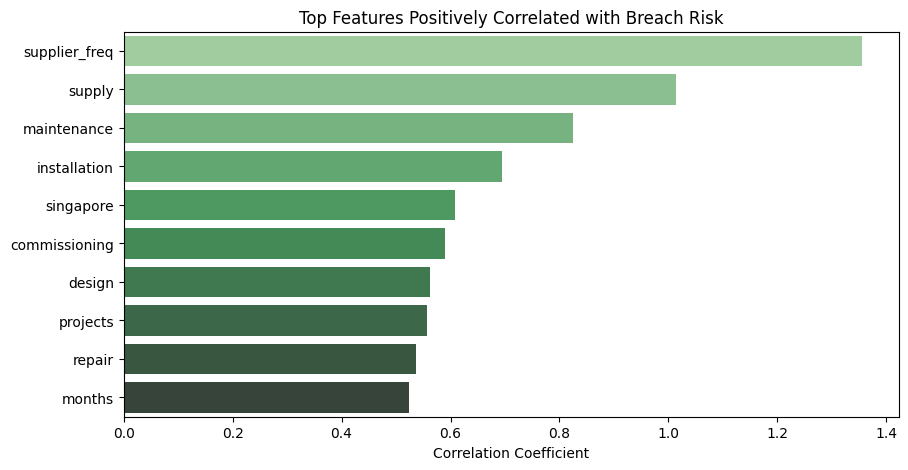

C:\tmp\ipykernel_6400\3343952291.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(neg_features.values()), y=list(neg_features.keys()), palette="Reds_r")


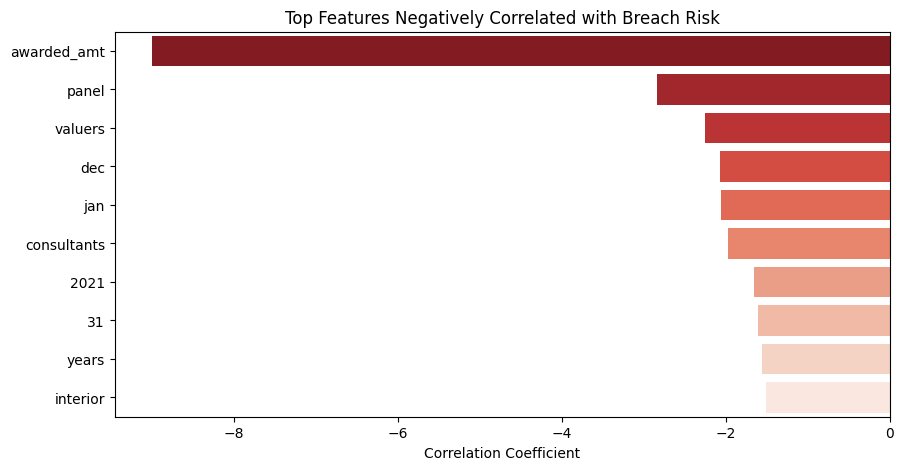

In [21]:
#Visulaize top posisitve and negative correlated features
import matplotlib.pyplot as plt
import seaborn as sns

# Example data from your correlation output
pos_features = {
    'supplier_freq': 1.3547,
    'supply': 1.0147,
    'maintenance': 0.8244,
    'installation': 0.6949,
    'singapore': 0.6080,
    'commissioning': 0.5908,
    'design': 0.5616,
    'projects': 0.5561,
    'repair': 0.5362,
    'months': 0.5240
}

neg_features = {
    'awarded_amt': -9.0006,
    'panel': -2.8432,
    'valuers': -2.2485,
    'dec': -2.0692,
    'jan': -2.0603,
    'consultants': -1.9727,
    '2021': -1.6602,
    '31': -1.6030,
    'years': -1.5550,
    'interior': -1.5060
}

# Plotting positive correlations
plt.figure(figsize=(10,5))
sns.barplot(x=list(pos_features.values()), y=list(pos_features.keys()), palette="Greens_d")
plt.title('Top Features Positively Correlated with Breach Risk')
plt.xlabel('Correlation Coefficient')
plt.show()

# Plotting negative correlations
plt.figure(figsize=(10,5))
sns.barplot(x=list(neg_features.values()), y=list(neg_features.keys()), palette="Reds_r")
plt.title('Top Features Negatively Correlated with Breach Risk')
plt.xlabel('Correlation Coefficient')
plt.show()


<Figure size 1500x600 with 0 Axes>

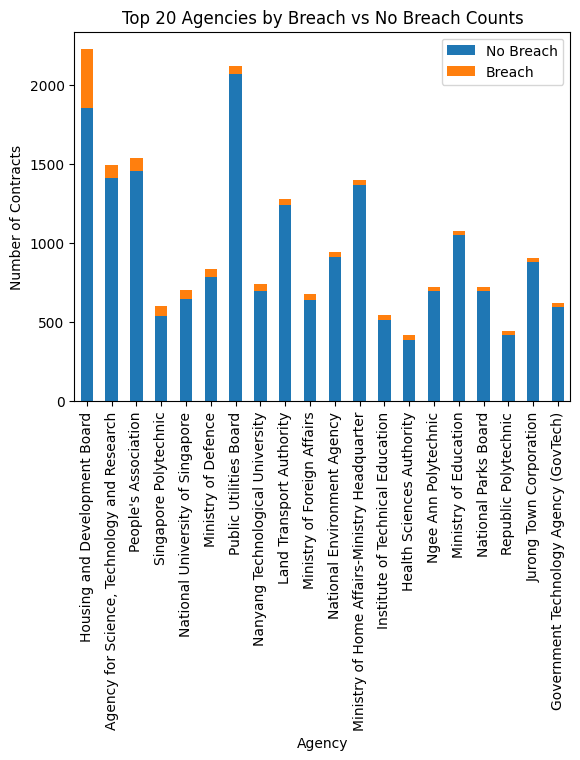

In [27]:
#Visualize breach vs no breach distribution across agencies, suppliers, or contract amounts
#a. Bar plot for breach counts by agency
plt.figure(figsize=(15,6))
breach_counts = df.groupby(['agency', 'breach_risk']).size().unstack().fillna(0)
breach_counts.sort_values(by=1, ascending=False).head(20).plot(kind='bar', stacked=True)
plt.title('Top 20 Agencies by Breach vs No Breach Counts')
plt.xlabel('Agency')
plt.ylabel('Number of Contracts')
plt.legend(['No Breach', 'Breach'])
plt.show()


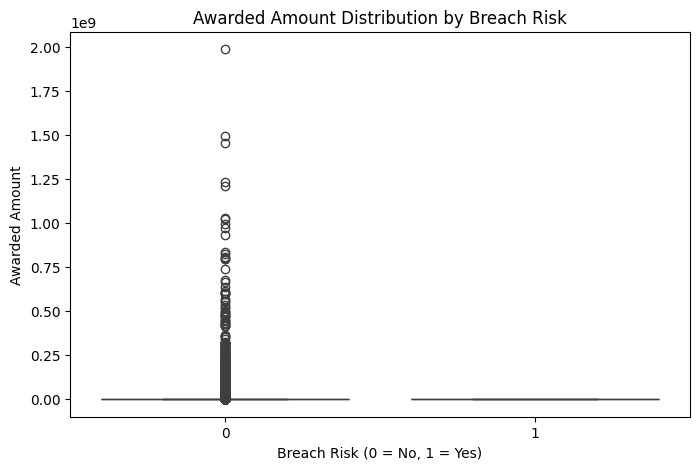

In [28]:
plt.figure(figsize=(8,5))
sns.boxplot(x='breach_risk', y='awarded_amt', data=df)
plt.title('Awarded Amount Distribution by Breach Risk')
plt.xlabel('Breach Risk (0 = No, 1 = Yes)')
plt.ylabel('Awarded Amount')
plt.show()


In [29]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


NameError: name 'y_probs' is not defined

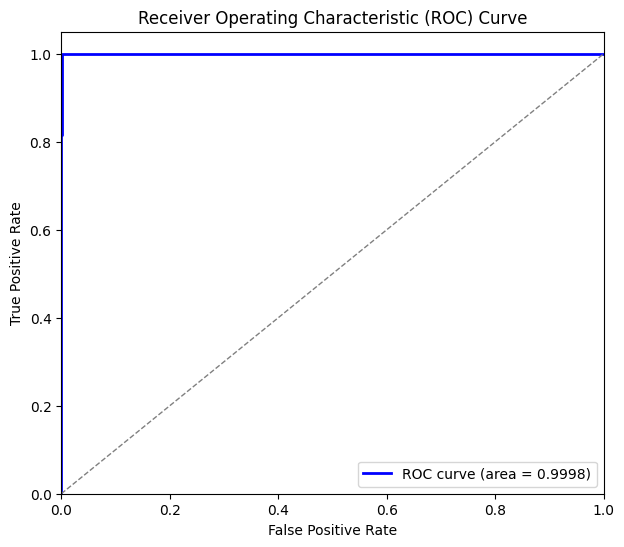

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Example: Create supplier summary dataframe
supplier_summary = df.groupby('supplier_name').agg({
    'awarded_amt': 'mean',
    'tender_no.': 'count',  # frequency of contracts
    'breach_risk_score': 'mean'  # predicted probability from your model
}).rename(columns={'tender_no.': 'supplier_freq'})

# Scale data
scaler = StandardScaler()
supplier_scaled = scaler.fit_transform(supplier_summary)



KeyError: "Column(s) ['breach_risk_score'] do not exist"

In [32]:
print(df.columns)


Index(['tender_no.', 'tender_description', 'agency', 'award_date',
       'tender_detail_status', 'supplier_name', 'awarded_amt', 'breach_risk',
       'award_month', 'award_year', 'agency_freq', 'supplier_freq'],
      dtype='object')


In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Clean column names just in case
df.columns = df.columns.str.strip()

# Create supplier summary dataframe
supplier_summary = df.groupby('supplier_name').agg({
    'awarded_amt': 'mean',
    'tender_no.': 'count',  # frequency of contracts
    'breach_risk': 'mean'   # corrected column name
}).rename(columns={'tender_no.': 'supplier_freq'})

# Scale data
scaler = StandardScaler()
supplier_scaled = scaler.fit_transform(supplier_summary)


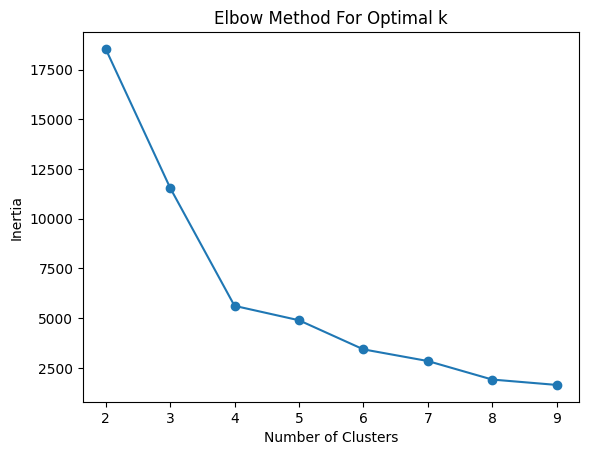

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Elbow method
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(supplier_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2,10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Pick k, say 3
kmeans = KMeans(n_clusters=3, random_state=42)
supplier_summary['cluster'] = kmeans.fit_predict(supplier_scaled)


In [35]:
print(supplier_summary.groupby('cluster').mean())


          awarded_amt  supplier_freq  breach_risk
cluster                                          
0        4.942377e+06       3.614855     0.001427
1        0.000000e+00    1414.000000     1.000000
2        2.465187e+05       6.089286     0.723861


In [36]:
# Add predicted risk to your main dataframe
df['risk_score'] = model.predict_proba(X)[:, 1]

# Define risk categories (example thresholds)
def risk_category(score):
    if score > 0.7:
        return 'High Risk'
    elif score > 0.4:
        return 'Medium Risk'
    else:
        return 'Low Risk'

df['risk_category'] = df['risk_score'].apply(risk_category)


In [37]:
print(df['risk_category'].value_counts())


risk_category
Low Risk       30959
High Risk       1774
Medium Risk       23
Name: count, dtype: int64


In [39]:
print(df.columns.tolist())


['tender_no.', 'tender_description', 'agency', 'award_date', 'tender_detail_status', 'supplier_name', 'awarded_amt', 'breach_risk', 'award_month', 'award_year', 'agency_freq', 'supplier_freq', 'risk_score', 'risk_category']


In [40]:
supplier_summary = df.groupby('supplier_name').agg({
    'awarded_amt': 'mean',
    'tender_no.': 'count',
    'risk_score': 'mean'  # correct column name
}).rename(columns={
    'tender_no.': 'supplier_freq',
    'risk_score': 'breach_risk_score'  # rename for plotting
})


In [41]:
supplier_summary = supplier_summary.reset_index()


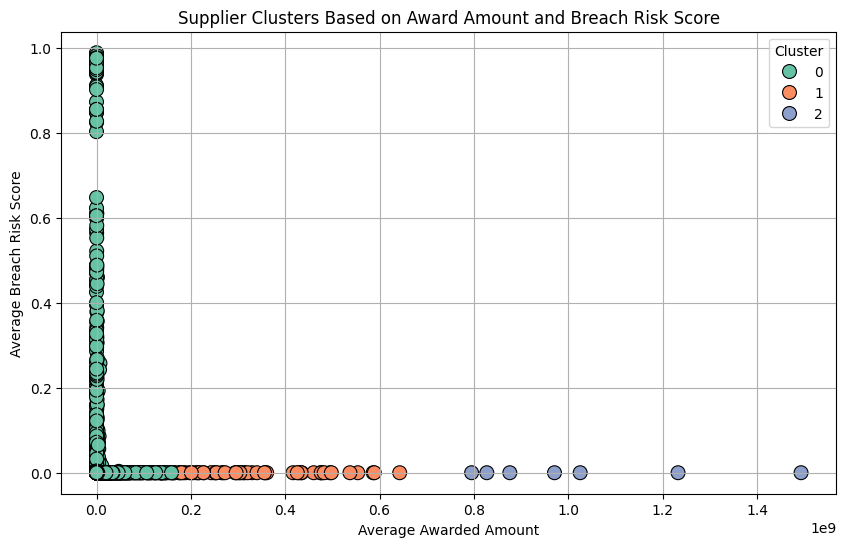

In [43]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Group and rename
supplier_summary = df.groupby('supplier_name').agg({
    'awarded_amt': 'mean',
    'tender_no.': 'count',
    'risk_score': 'mean'
}).rename(columns={
    'tender_no.': 'supplier_freq',
    'risk_score': 'breach_risk_score'
}).reset_index()

# Step 2: Apply KMeans clustering (choose n_clusters based on your use case)
kmeans = KMeans(n_clusters=3, random_state=42)
supplier_summary['cluster'] = kmeans.fit_predict(supplier_summary[['awarded_amt', 'breach_risk_score']])

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=supplier_summary,
    x='awarded_amt',
    y='breach_risk_score',
    hue='cluster',
    palette='Set2',
    s=100,
    edgecolor='black'
)

plt.title('Supplier Clusters Based on Award Amount and Breach Risk Score')
plt.xlabel('Average Awarded Amount')
plt.ylabel('Average Breach Risk Score')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


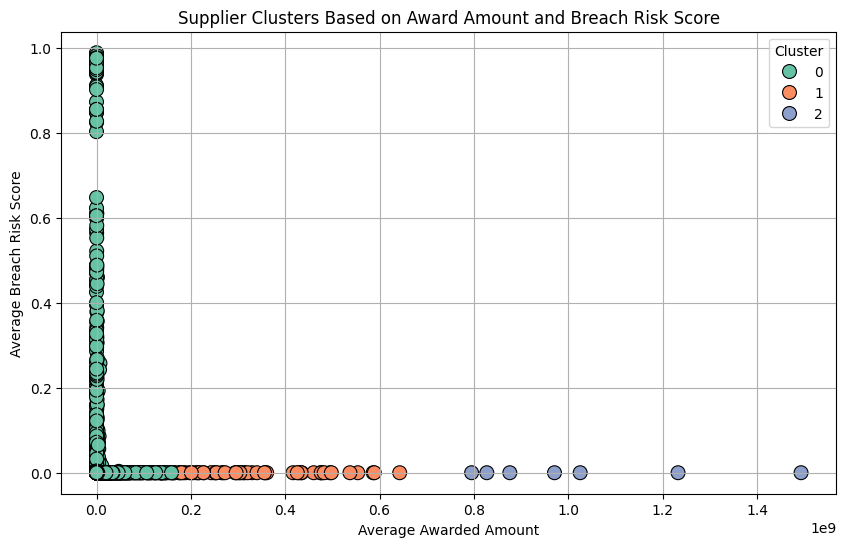

In [44]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Group and rename
supplier_summary = df.groupby('supplier_name').agg({
    'awarded_amt': 'mean',
    'tender_no.': 'count',
    'risk_score': 'mean'
}).rename(columns={
    'tender_no.': 'supplier_freq',
    'risk_score': 'breach_risk_score'
}).reset_index()

# Step 2: Apply KMeans clustering (choose n_clusters based on your use case)
kmeans = KMeans(n_clusters=3, random_state=42)
supplier_summary['cluster'] = kmeans.fit_predict(supplier_summary[['awarded_amt', 'breach_risk_score']])

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=supplier_summary,
    x='awarded_amt',
    y='breach_risk_score',
    hue='cluster',
    palette='Set2',
    s=100,
    edgecolor='black'
)

plt.title('Supplier Clusters Based on Award Amount and Breach Risk Score')
plt.xlabel('Average Awarded Amount')
plt.ylabel('Average Breach Risk Score')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
